In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/N/slate/qmnguyen/projects/future-sst-prediction-diffusion


In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Lambda
from tqdm.auto import tqdm

from sst import (
    ConditionalBackwardSampler,
    ForwardSampler,
    LinearBetaScheduler,
)
from sst.dataset import NOAA_OI_SST, Difference_NOAA_OI_SST
from sst.dataset.transforms import ScaleTemperature
from sst.layers import SinusoidalPositionEncoding
from sst.training_procedures import ConditionalOnPastSSTTrainingProcedure

# Future SST Difference Prediction using Fully Connected Networks with Conditional Diffusion

In this experiment,
I will try to implement the idea of Saharia et al. (2022) to predict future SST
conditioning on the past 4-day SST.
But instead of using UNet architecture, I will just use a normal fully-connected network.

## Dataset

Similar to that of [sst_unconditional_diffusion.py](./sst_unconditional_diffusion.py):

In [3]:
temp_diff_scaler = ScaleTemperature(min_temp=0, max_temp=1)
transform_fn = Compose([
    # temp_diff_scaler,
    # Lambda(lambda s: (2*s[0] - 1, 2*s[1] - 1))
])
train_ds = NOAA_OI_SST(train=True)
train_ds = Difference_NOAA_OI_SST(
    train_ds, transform=transform_fn)

We will want to split the data into training and validation data using 20% split:
80% for training and 20% for validation.

In [4]:
train_size = int(len(train_ds) * 0.8)
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
print(f'{train_size=} {len(train_ds)=}')
print(f'{val_size=} {len(val_ds)=}')

train_size=75129 len(train_ds)=75129
val_size=18783 len(val_ds)=18783


In addition, we will need test dataset for this experiment.

In [5]:
test_ds = NOAA_OI_SST(train=False)
test_diff_ds = Difference_NOAA_OI_SST(
    test_ds, transform=transform_fn)
print(f'{len(test_ds)=}')

len(test_ds)=2892


## Fully-Connected Network

In [6]:
class FutureSSTNoisePredictionModel(nn.Module):
    def __init__(self, nb_past_observations: int) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEncoding(24 * 24),
            nn.Linear(24*24, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )
        self.first = nn.Sequential(
            nn.Linear(24*24, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )

        self.past_observation_mlp = nn.Sequential(
            nn.Linear(24*24*nb_past_observations, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )

        self.hidden = nn.Sequential(
            # Encoder.
            nn.Linear(4096, 2048), nn.LayerNorm(2048), nn.SiLU(),
            # # Decoder.
            nn.Linear(2048, 24 * 24),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 24, 24))


    def forward(self, noisy_sst: torch.Tensor, past_sst: torch.Tensor, time_steps: torch.Tensor):
        # Process noisy SST.
        x1 = self.flatten(noisy_sst)
        x1 = self.first(x1)
        x1 += self.time_mlp(time_steps)

        # Process past SST.
        x2 = self.flatten(past_sst)
        x2 = self.past_observation_mlp(x2)

        # Concatenate the noisy SST and past SST.
        x = torch.concat([x1, x2], dim=1)

        x = self.hidden(x)
        x = self.unflatten(x)
        return x

### Training

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


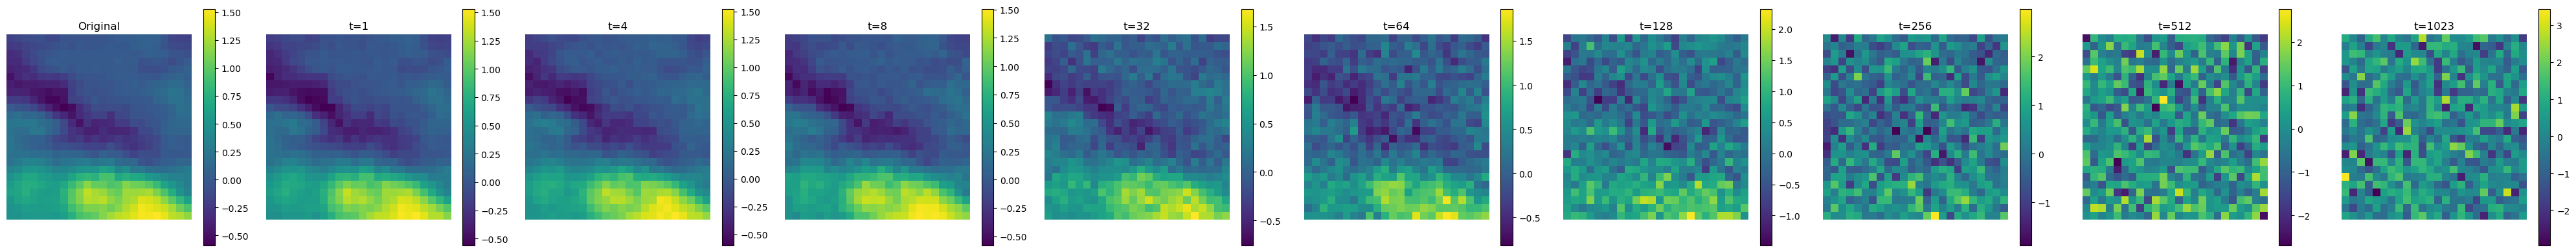

In [8]:
beta_scheduler = LinearBetaScheduler(1e-4, 0.02, 1024)
forward_sampler = ForwardSampler(beta_scheduler)

# I didn't verify whether the forward sampler is doing what we expect.
# So let's do it now.
time_steps = [1, 4, 8, 32, 64, 128, 256, 512, 1023]
fig, axes = plt.subplots(
    ncols=len(time_steps) + 1,
    figsize=(4 * len(time_steps) + 4, 4))
for ax, t in zip(axes[1:], time_steps):
    _, sst = train_ds[2555]
    sst = torch.tensor(sst)
    noisy_sst, _ = forward_sampler(sst, torch.tensor(t))
    cs = ax.imshow(noisy_sst[0])
    fig.colorbar(cs, ax=ax)
    ax.axis('off')
    ax.set_title(f'{t=}')

ax = axes[0]
cs = ax.imshow(sst[0])
fig.colorbar(cs, ax=ax)
ax.axis('off')
ax.set_title('Original')
fig.tight_layout()

It looks good!

Now, we will train the model.

In [9]:
model = FutureSSTNoisePredictionModel(3)
training_procedure = ConditionalOnPastSSTTrainingProcedure(model, forward_sampler, device)

train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_ds, batch_size=256, num_workers=4)

epochs = 1 if device == 'cpu' else 500
for epoch in range(epochs):
    train_loss = training_procedure.train(train_dataloader, epoch)
    val_loss = training_procedure.evaluate(val_dataloader)

    print(f'{train_loss=} {val_loss=}')

Skipped init weight for module m=Flatten(start_dim=1, end_dim=-1).
Skipped init weight for module m=SinusoidalPositionEncoding().
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): SinusoidalPositionEncoding()
  (1): Linear(in_features=576, out_features=2048, bias=True)
  (2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (3): SiLU()
).
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): Linear(in_features=576, out_features=2048, bias=True)
  (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (2): SiLU()
).
Skipped init weight for module m=LayerNorm((2048,), eps=1e-05, elementwise_affine=True).
Skipped init weight for module m=SiLU().
Skipped init weight for module m=Sequential(
  (0): Linear(in_features=172

Training epoch 0:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.1695730592675355 val_loss=0.07750182427667282


Training epoch 1:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0682921102967392 val_loss=0.06187056171128879


Training epoch 2:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.056832934609379895 val_loss=0.05141834884479239


Training epoch 3:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.04777744559406423 val_loss=0.04491267081450771


Training epoch 4:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.040802537736033095 val_loss=0.03884226048516261


Training epoch 5:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03661172304201086 val_loss=0.03473254605322271


Training epoch 6:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03368652227404369 val_loss=0.03434827005037585


Training epoch 7:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.032020432785862966 val_loss=0.031220277746182842


Training epoch 8:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.03058541905717785 val_loss=0.029874095340838302


Training epoch 9:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02944645013812245 val_loss=0.02806596173527273


Training epoch 10:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.028263326886357094 val_loss=0.02783621830009931


Training epoch 11:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.027624917938849147 val_loss=0.02803283861863452


Training epoch 12:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.026597033615927308 val_loss=0.02640836829369938


Training epoch 13:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.026291579090464277 val_loss=0.027226402248079713


Training epoch 14:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02574264641445713 val_loss=0.026035734477478104


Training epoch 15:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02515244310987847 val_loss=0.024675775344508724


Training epoch 16:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.024785061550586403 val_loss=0.02453882571913906


Training epoch 17:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.024106963879751916 val_loss=0.02400942949729191


Training epoch 18:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02400760499595785 val_loss=0.024445156969532773


Training epoch 19:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.023736873198123204 val_loss=0.02340208781832779


Training epoch 20:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.023358109103021572 val_loss=0.023362469330832764


Training epoch 21:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.023116972769426855 val_loss=0.023075492574355087


Training epoch 22:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022974663395054485 val_loss=0.023271126848821704


Training epoch 23:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.022387753120389115 val_loss=0.022762575891573687


Training epoch 24:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02241445210489894 val_loss=0.02205672374347577


Training epoch 25:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02207262047129322 val_loss=0.022014211510887016


Training epoch 26:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021849539536399905 val_loss=0.02176065113697503


Training epoch 27:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021942036492483958 val_loss=0.02167178948435026


Training epoch 28:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02169189412704333 val_loss=0.021810707308956095


Training epoch 29:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021341611536181703 val_loss=0.0212843271626814


Training epoch 30:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02122508603635998 val_loss=0.021423230677641725


Training epoch 31:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020986965227061186 val_loss=0.021278824581689126


Training epoch 32:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020732893057319582 val_loss=0.021350925662428945


Training epoch 33:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.021040991189427115 val_loss=0.021191817569873622


Training epoch 34:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02074116198852861 val_loss=0.020716359033375174


Training epoch 35:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02030650760699697 val_loss=0.021383856221832132


Training epoch 36:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.02000447620834116 val_loss=0.020261061340067034


Training epoch 37:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020451155921989154 val_loss=0.02082516620489391


Training epoch 38:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0202678636216945 val_loss=0.020399426777117157


Training epoch 39:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019897091072559558 val_loss=0.020836405154015566


Training epoch 40:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019877186333317132 val_loss=0.020014057388982258


Training epoch 41:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020033474127781028 val_loss=0.019937599191089738


Training epoch 42:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01971119628636306 val_loss=0.020635061909922876


Training epoch 43:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.020020306262434746 val_loss=0.020163606663511413


Training epoch 44:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019825093856803616 val_loss=0.019463623936816648


Training epoch 45:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0195889902256784 val_loss=0.019710375235189457


Training epoch 46:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019493820703252642 val_loss=0.019522995826461026


Training epoch 47:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019798570483618855 val_loss=0.01995763974264264


Training epoch 48:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01945554097594858 val_loss=0.020326632930821664


Training epoch 49:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019513603499425308 val_loss=0.020171403910058575


Training epoch 50:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01975101494819534 val_loss=0.019570850200850417


Training epoch 51:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0193760769479737 val_loss=0.020506108821545903


Training epoch 52:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01928172417010377 val_loss=0.02017944267120313


Training epoch 53:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01921586386644009 val_loss=0.019545823335647583


Training epoch 54:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0196030654494657 val_loss=0.020076799055410398


Training epoch 55:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019259135346530246 val_loss=0.019516828281150478


Training epoch 56:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01950144095244963 val_loss=0.019345542340463883


Training epoch 57:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01929920303895056 val_loss=0.02020719983438785


Training epoch 58:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019150107696677753 val_loss=0.01977598390265091


Training epoch 59:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01911218313905759 val_loss=0.019562328712561645


Training epoch 60:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019095104647052732 val_loss=0.019468773231917137


Training epoch 61:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019124001939305846 val_loss=0.01970414473750704


Training epoch 62:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0191281670704484 val_loss=0.019377726444823516


Training epoch 63:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019195246681266903 val_loss=0.01916251008121951


Training epoch 64:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019123655050156677 val_loss=0.01938988405556695


Training epoch 65:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018619891097705787 val_loss=0.01854688411175802


Training epoch 66:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.019009521310249355 val_loss=0.01863884424941765


Training epoch 67:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018554415138831146 val_loss=0.018710569453400536


Training epoch 68:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018807047376168423 val_loss=0.019155362054604937


Training epoch 69:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018887486948701394 val_loss=0.019121407292078476


Training epoch 70:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018837294629996733 val_loss=0.019158599923389988


Training epoch 71:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018770423898359343 val_loss=0.018960259137423458


Training epoch 72:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018321131720353347 val_loss=0.018438632763620164


Training epoch 73:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018790039053300813 val_loss=0.018885101116186864


Training epoch 74:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018749348651364343 val_loss=0.018640564666507212


Training epoch 75:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01880906860907974 val_loss=0.018678998461345565


Training epoch 76:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01870784467580367 val_loss=0.018742808833013515


Training epoch 77:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018504039812072808 val_loss=0.019320054004925327


Training epoch 78:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01845755542432066 val_loss=0.018795475804221792


Training epoch 79:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01848284508652833 val_loss=0.018235802386157417


Training epoch 80:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018324101144181832 val_loss=0.018597673863877315


Training epoch 81:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018701289501674725 val_loss=0.018628577487794933


Training epoch 82:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018539856200670304 val_loss=0.018889230889947834


Training epoch 83:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018390573279260577 val_loss=0.01858987012324301


Training epoch 84:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01832365132171382 val_loss=0.018535036606261053


Training epoch 85:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018390651016185682 val_loss=0.01855836051037988


Training epoch 86:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018356079698166473 val_loss=0.018552523861463006


Training epoch 87:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018153924995488454 val_loss=0.018495203234960098


Training epoch 88:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018267354760065573 val_loss=0.018267154542578233


Training epoch 89:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018496327694556138 val_loss=0.018294961657375097


Training epoch 90:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018487747296133415 val_loss=0.018532886711024755


Training epoch 91:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018357361384927214 val_loss=0.017527549817050632


Training epoch 92:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01834497175046376 val_loss=0.018002146414506273


Training epoch 93:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018197420122874838 val_loss=0.017944525360960414


Training epoch 94:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018234591300719652 val_loss=0.018422695153669733


Training epoch 95:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01786373394104291 val_loss=0.018616711418773677


Training epoch 96:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018171107352134726 val_loss=0.018316137063241488


Training epoch 97:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0179402255484847 val_loss=0.018244910758693476


Training epoch 98:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017978706032823342 val_loss=0.018693947522724803


Training epoch 99:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01816645976738865 val_loss=0.01848149484627553


Training epoch 100:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.018150758501902526 val_loss=0.018848833300777385


Training epoch 101:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0179613439721011 val_loss=0.017980258937018948


Training epoch 102:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017909154615865477 val_loss=0.017873048367029108


Training epoch 103:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0180975675525866 val_loss=0.0180427360449087


Training epoch 104:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01780645328820968 val_loss=0.017934386152774096


Training epoch 105:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01780174831625353 val_loss=0.018495744648011955


Training epoch 106:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0181668927310174 val_loss=0.01841417545251347


Training epoch 107:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017777262429776442 val_loss=0.01812146359903587


Training epoch 108:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01783237100078338 val_loss=0.018222302764754842


Training epoch 109:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01771887317363198 val_loss=0.018022312833046592


Training epoch 110:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01779965610325742 val_loss=0.01827344811848692


Training epoch 111:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01781528154831557 val_loss=0.017403438171321475


Training epoch 112:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0176270331009006 val_loss=0.017934031797119894


Training epoch 113:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017941572069868343 val_loss=0.017252727248076652


Training epoch 114:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017797493673607605 val_loss=0.018044996591335214


Training epoch 115:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017677303020316525 val_loss=0.018380961443826154


Training epoch 116:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017706694255652678 val_loss=0.01806124036728933


Training epoch 117:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017727900404153632 val_loss=0.017694967874401325


Training epoch 118:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01775583069214002 val_loss=0.017540194459158828


Training epoch 119:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017798189545797857 val_loss=0.017679509518013614


Training epoch 120:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01795758071932055 val_loss=0.01792753625006692


Training epoch 121:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017820509242489426 val_loss=0.01713892394626463


Training epoch 122:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017529994819541365 val_loss=0.017910027423420467


Training epoch 123:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017749203128271364 val_loss=0.017873790127703466


Training epoch 124:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017502659567486065 val_loss=0.017470390447792975


Training epoch 125:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017575951118883836 val_loss=0.018140583248758637


Training epoch 126:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017450002129791545 val_loss=0.01818284043740179


Training epoch 127:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01744035914616317 val_loss=0.01782048152558304


Training epoch 128:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017575139756358805 val_loss=0.01762739074340946


Training epoch 129:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017454346692582376 val_loss=0.01769480124317311


Training epoch 130:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017548723529618816 val_loss=0.017756588731867237


Training epoch 131:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01759329627325036 val_loss=0.01762662670650595


Training epoch 132:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017504998432079547 val_loss=0.01815630657900427


Training epoch 133:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01764299097109814 val_loss=0.01760641548379853


Training epoch 134:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01751140983091021 val_loss=0.018239655443844763


Training epoch 135:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017335087510750812 val_loss=0.017684399855096598


Training epoch 136:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017329693258721 val_loss=0.017303398785156174


Training epoch 137:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01750340127088383 val_loss=0.017320230880097764


Training epoch 138:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017375029256047846 val_loss=0.01780152410218442


Training epoch 139:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017542450657101714 val_loss=0.017848610575940158


Training epoch 140:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017323865710447233 val_loss=0.017618071879386098


Training epoch 141:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017554370135220945 val_loss=0.018031497800571693


Training epoch 142:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017236219795078646 val_loss=0.017446559388190508


Training epoch 143:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01736056442264797 val_loss=0.01764064093397276


Training epoch 144:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01733967550352317 val_loss=0.017481186351663357


Training epoch 145:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017307861093558422 val_loss=0.017571693047176342


Training epoch 146:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01733533025966311 val_loss=0.017687902559299726


Training epoch 147:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017379275114484588 val_loss=0.017710446795398318


Training epoch 148:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017533230756846617 val_loss=0.017055351350053743


Training epoch 149:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017101028642686856 val_loss=0.01825988690394002


Training epoch 150:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017126156989687762 val_loss=0.017369777140383784


Training epoch 151:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017223077002583312 val_loss=0.017266812960843782


Training epoch 152:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01701679941406157 val_loss=0.017541780514088837


Training epoch 153:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017245717650773575 val_loss=0.01798485284922896


Training epoch 154:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017331569107109996 val_loss=0.017210337496991898


Training epoch 155:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01741132309318197 val_loss=0.017345617928013608


Training epoch 156:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01709126812868378 val_loss=0.01757920069015912


Training epoch 157:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01716169038926866 val_loss=0.017471944497948564


Training epoch 158:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017198242278782284 val_loss=0.01721644143548769


Training epoch 159:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01710087841148583 val_loss=0.01745524603521099


Training epoch 160:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01721259397866369 val_loss=0.01673739470189085


Training epoch 161:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01717469908081654 val_loss=0.017455251358852193


Training epoch 162:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017306045898344037 val_loss=0.017323188798351062


Training epoch 163:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017277623960735643 val_loss=0.01680960416844165


Training epoch 164:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01687050663365596 val_loss=0.017363450741647062


Training epoch 165:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01741179744047778 val_loss=0.017372948457361072


Training epoch 166:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017241931735810373 val_loss=0.01688231698967315


Training epoch 167:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01734551755698765 val_loss=0.017484717347936052


Training epoch 168:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017105091518412035 val_loss=0.017498257834262943


Training epoch 169:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016930546902981746 val_loss=0.017399809675643575


Training epoch 170:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017127307230087162 val_loss=0.016994767243394982


Training epoch 171:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01717074366514476 val_loss=0.017312472937880335


Training epoch 172:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016896168387742067 val_loss=0.01715891229341159


Training epoch 173:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016914084192593486 val_loss=0.017754849562471784


Training epoch 174:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01702980832101739 val_loss=0.017413095772467756


Training epoch 175:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016948976167509344 val_loss=0.017426858593181178


Training epoch 176:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016896008874992936 val_loss=0.01739914534059731


Training epoch 177:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017093545019145118 val_loss=0.01718413525235814


Training epoch 178:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01681617119343204 val_loss=0.016890868192186225


Training epoch 179:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017122505406918776 val_loss=0.017296987963286607


Training epoch 180:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017046755620082017 val_loss=0.016681330719006224


Training epoch 181:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016773314123377712 val_loss=0.017059375519386015


Training epoch 182:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017019161457183206 val_loss=0.01761989646616417


Training epoch 183:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01698280008015584 val_loss=0.017194464991523606


Training epoch 184:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016967962283742467 val_loss=0.016794473209695238


Training epoch 185:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017029158498610364 val_loss=0.017260225376466643


Training epoch 186:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016693785089720675 val_loss=0.01691346606743094


Training epoch 187:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01679156900250486 val_loss=0.016757601607792282


Training epoch 188:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017146625799969548 val_loss=0.017389813261861738


Training epoch 189:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016894935357834207 val_loss=0.016828885188678634


Training epoch 190:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017151568316201977 val_loss=0.01717417879734893


Training epoch 191:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016981575295937305 val_loss=0.017450075886036094


Training epoch 192:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01668610834028749 val_loss=0.017047721049370797


Training epoch 193:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01692413351796314 val_loss=0.017457745428121573


Training epoch 194:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.017077780933733903 val_loss=0.016906519684739208


Training epoch 195:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01676012176488127 val_loss=0.017113881563214032


Training epoch 196:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016698337993172763 val_loss=0.01700419684670664


Training epoch 197:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016938822115866507 val_loss=0.016915087474862468


Training epoch 198:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016851356835896465 val_loss=0.017252641151080262


Training epoch 199:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0167318319673745 val_loss=0.016759320640483417


Training epoch 200:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016801763623699444 val_loss=0.016588955664554157


Training epoch 201:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01688447370364958 val_loss=0.0165663855779614


Training epoch 202:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016442952915189827 val_loss=0.01700994391246019


Training epoch 203:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016545393649919502 val_loss=0.016649082768708467


Training epoch 204:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016985154197532302 val_loss=0.017158690852591314


Training epoch 205:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016670443586447613 val_loss=0.01711872564880429


Training epoch 206:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016651060219955483 val_loss=0.017099230474716908


Training epoch 207:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01674361168375226 val_loss=0.017152761461565625


Training epoch 208:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016906443672875564 val_loss=0.01727061772819709


Training epoch 209:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01681162278820463 val_loss=0.016418748711412016


Training epoch 210:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01651447223258667 val_loss=0.016821400501538773


Training epoch 211:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01679789671534989 val_loss=0.016668843256460654


Training epoch 212:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01646643779462292 val_loss=0.01701748843078275


Training epoch 213:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016777640918181055 val_loss=0.017001346647235994


Training epoch 214:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016580562138942635 val_loss=0.01679410507298402


Training epoch 215:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016713965905918962 val_loss=0.0166280440658935


Training epoch 216:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016852679408985338 val_loss=0.017032332630274264


Training epoch 217:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01699927383970444 val_loss=0.016688967324994707


Training epoch 218:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016633518851127755 val_loss=0.01658262001551889


Training epoch 219:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01651927672617999 val_loss=0.016678321238204435


Training epoch 220:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01671302751923094 val_loss=0.017173638605084772


Training epoch 221:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016462665111409362 val_loss=0.01687290527027201


Training epoch 222:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016957780016826934 val_loss=0.016794695380471042


Training epoch 223:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016422519650386304 val_loss=0.01687894153685586


Training epoch 224:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016596352152501038 val_loss=0.016625655601052818


Training epoch 225:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016649527782510942 val_loss=0.016928349747448355


Training epoch 226:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016729968283198723 val_loss=0.016753449696242005


Training epoch 227:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016588367100450255 val_loss=0.016833881407069998


Training epoch 228:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0165615368438061 val_loss=0.016627796963360662


Training epoch 229:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016733307578303172 val_loss=0.016689394474835008


Training epoch 230:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016485462247134267 val_loss=0.016676596290356404


Training epoch 231:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016403890360577576 val_loss=0.01659062015194748


Training epoch 232:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01646070933400267 val_loss=0.01700510974419681


Training epoch 233:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016872524492898767 val_loss=0.01647924109538262


Training epoch 234:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016213996180643637 val_loss=0.016409799280400213


Training epoch 235:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016588345635682344 val_loss=0.01689413231419953


Training epoch 236:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01667496518288948 val_loss=0.01652111505737176


Training epoch 237:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016558063685336487 val_loss=0.01735389243962394


Training epoch 238:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016535218662525317 val_loss=0.01660844762935429


Training epoch 239:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016358983731467505 val_loss=0.016497794777859707


Training epoch 240:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016619080978566084 val_loss=0.01641925353858922


Training epoch 241:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016710978352977912 val_loss=0.016319497488439083


Training epoch 242:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01647359497376344 val_loss=0.01693114681119049


Training epoch 243:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016634387049671948 val_loss=0.016655252239591366


Training epoch 244:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016400583398838837 val_loss=0.01702945542244895


Training epoch 245:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01645446624163361 val_loss=0.01669906418317476


Training epoch 246:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01647121712983567 val_loss=0.016259825498973195


Training epoch 247:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016462623243074435 val_loss=0.01705430930077627


Training epoch 248:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016614234112963384 val_loss=0.016336303783228267


Training epoch 249:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016397622904936675 val_loss=0.016462069344580978


Training epoch 250:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016541621258140217 val_loss=0.01673484073851157


Training epoch 251:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016691630085309345 val_loss=0.01698520584535357


Training epoch 252:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016589160371875883 val_loss=0.016447387484682573


Training epoch 253:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016482931184804157 val_loss=0.016219450299300858


Training epoch 254:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016415627267794546 val_loss=0.016500790225895675


Training epoch 255:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016453388118546228 val_loss=0.01650613480927171


Training epoch 256:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01646715329111028 val_loss=0.016351820259178813


Training epoch 257:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016323200803959652 val_loss=0.016356816074836092


Training epoch 258:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01635765492421936 val_loss=0.016130377488160454


Training epoch 259:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016323558339963153 val_loss=0.016514933919785795


Training epoch 260:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016608838406929963 val_loss=0.016031021415885235


Training epoch 261:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016541400807117728 val_loss=0.016579522260439558


Training epoch 262:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016511432478064986 val_loss=0.016529059213762347


Training epoch 263:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01652854621461054 val_loss=0.01655277452507132


Training epoch 264:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016211918659736306 val_loss=0.016341652985460853


Training epoch 265:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016338551084377935 val_loss=0.016453393948944035


Training epoch 266:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01628501122804726 val_loss=0.01605346133127003


Training epoch 267:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016263901097636646 val_loss=0.01688072266610893


Training epoch 268:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01649955291060262 val_loss=0.016637816823817587


Training epoch 269:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016538255635750333 val_loss=0.017064559701326733


Training epoch 270:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016404253037861822 val_loss=0.01683666302847701


Training epoch 271:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016689730405832836 val_loss=0.016313598856229235


Training epoch 272:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016509681588456948 val_loss=0.016707490072459787


Training epoch 273:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01639228281533333 val_loss=0.01606601515684176


Training epoch 274:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015994601601063193 val_loss=0.016525514285407356


Training epoch 275:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0165287184079184 val_loss=0.016944913394950533


Training epoch 276:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016147087926843336 val_loss=0.016217717976384872


Training epoch 277:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016299183502615916 val_loss=0.016086836546860838


Training epoch 278:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016244094299317217 val_loss=0.016427292306026495


Training epoch 279:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016391743167753325 val_loss=0.016156539471971022


Training epoch 280:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016392275529476454 val_loss=0.01694011110560717


Training epoch 281:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016433067787692053 val_loss=0.016221635081377382


Training epoch 282:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016391942695695525 val_loss=0.016371576744761016


Training epoch 283:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016088067791519726 val_loss=0.01629512748253104


Training epoch 284:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016387556559171807 val_loss=0.016222853402330262


Training epoch 285:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01629452324364664 val_loss=0.016608939934018498


Training epoch 286:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016174151441779267 val_loss=0.016671201554001182


Training epoch 287:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016391345065365843 val_loss=0.01647679618484265


Training epoch 288:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016038477230741054 val_loss=0.016171957504608342


Training epoch 289:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01615196696425579 val_loss=0.016163918063850015


Training epoch 290:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016353657608535015 val_loss=0.016168602654156653


Training epoch 291:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016111903684530533 val_loss=0.016588509460357396


Training epoch 292:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016412572507575458 val_loss=0.016176859231514705


Training epoch 293:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01615665820078785 val_loss=0.01643980513452678


Training epoch 294:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01627259080925462 val_loss=0.015683457356046985


Training epoch 295:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016133813764012996 val_loss=0.016436363343854208


Training epoch 296:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016439537907361378 val_loss=0.01629377041968542


Training epoch 297:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01610257436337621 val_loss=0.017054660937975388


Training epoch 298:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016335180589967236 val_loss=0.016404456937232532


Training epoch 299:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016334159784399126 val_loss=0.016185027018592164


Training epoch 300:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01631623689959548 val_loss=0.016570732387638575


Training epoch 301:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016495202515958523 val_loss=0.016052860791820125


Training epoch 302:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016050865731145045 val_loss=0.01635823313247513


Training epoch 303:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01618412790858016 val_loss=0.016703616273966996


Training epoch 304:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016433456060508278 val_loss=0.016603073117801466


Training epoch 305:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016171394581241266 val_loss=0.01660630205092398


Training epoch 306:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01636435025922802 val_loss=0.016345097846980836


Training epoch 307:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016262972866799556 val_loss=0.01652689914949037


Training epoch 308:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015859472647714777 val_loss=0.016505996067378972


Training epoch 309:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01618250380872058 val_loss=0.016202518766796268


Training epoch 310:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016223491391255743 val_loss=0.0158582150029975


Training epoch 311:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016139029328819034 val_loss=0.01649694625489615


Training epoch 312:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016375052137617148 val_loss=0.016315928333111712


Training epoch 313:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01632046459090649 val_loss=0.015910443333858573


Training epoch 314:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015999351371535842 val_loss=0.01588084103187194


Training epoch 315:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016036813058668657 val_loss=0.016422711639992288


Training epoch 316:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01612245918055173 val_loss=0.01643844914144358


Training epoch 317:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01598595209787188 val_loss=0.016202163102256285


Training epoch 318:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01573316720916199 val_loss=0.0170046580149918


Training epoch 319:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016085483260503432 val_loss=0.016484541252154757


Training epoch 320:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016232229449285738 val_loss=0.016181814270345745


Training epoch 321:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01621641524668251 val_loss=0.016311891087507073


Training epoch 322:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016105979139327396 val_loss=0.015900352856496703


Training epoch 323:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016335239646588864 val_loss=0.01643729265275839


Training epoch 324:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01603955311105162 val_loss=0.016305454503241425


Training epoch 325:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01636108127581019 val_loss=0.016453613929853245


Training epoch 326:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01612025394174112 val_loss=0.016753928786194004


Training epoch 327:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015975125121320186 val_loss=0.01640226980167869


Training epoch 328:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015681105174859163 val_loss=0.01583854927102456


Training epoch 329:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015942318757780554 val_loss=0.01589716359268169


Training epoch 330:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016123478430747785 val_loss=0.016634952730020962


Training epoch 331:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01597494548693502 val_loss=0.016327628337249562


Training epoch 332:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016159422955393386 val_loss=0.015957406822692703


Training epoch 333:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016177898792385244 val_loss=0.01687046662728126


Training epoch 334:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016011571939274365 val_loss=0.015988218056893832


Training epoch 335:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016076385943206394 val_loss=0.016101977309665165


Training epoch 336:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016060846594802173 val_loss=0.016589865843589242


Training epoch 337:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016016476141402915 val_loss=0.01579084500318041


Training epoch 338:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01590117741198767 val_loss=0.016021183465380926


Training epoch 339:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016212024843180867 val_loss=0.016373322483756253


Training epoch 340:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01602317738112341 val_loss=0.016467238184870094


Training epoch 341:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016175295229443686 val_loss=0.016345417001158803


Training epoch 342:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015969036099481946 val_loss=0.015835047397460486


Training epoch 343:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01585495082319391 val_loss=0.016726282614006382


Training epoch 344:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016086842601827415 val_loss=0.015791045740951557


Training epoch 345:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0159659009952681 val_loss=0.016373983936736714


Training epoch 346:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0162773315579358 val_loss=0.015851797611528152


Training epoch 347:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015959817482171214 val_loss=0.016152897434359468


Training epoch 348:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0164361620467587 val_loss=0.01628912883382794


Training epoch 349:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015950168641347462 val_loss=0.015737201905230414


Training epoch 350:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01599252532825482 val_loss=0.01628548201374911


Training epoch 351:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016022959457976476 val_loss=0.016157740110380424


Training epoch 352:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016277793300699214 val_loss=0.01642527286517056


Training epoch 353:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015880100188308023 val_loss=0.016120098455733544


Training epoch 354:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01626133633980236 val_loss=0.015843796405337146


Training epoch 355:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01602044110788273 val_loss=0.01583197813581776


Training epoch 356:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01614572986529595 val_loss=0.016620372787017276


Training epoch 357:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01611169499224749 val_loss=0.016219098322294855


Training epoch 358:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016093050398971555 val_loss=0.016062986885977758


Training epoch 359:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01600855903471915 val_loss=0.016223345442700224


Training epoch 360:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015883430201864362 val_loss=0.015822619061312965


Training epoch 361:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01603083315679208 val_loss=0.015653057300762552


Training epoch 362:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01611494207057823 val_loss=0.016286626017677622


Training epoch 363:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016128805269594905 val_loss=0.016095397276552143


Training epoch 364:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015978421524901983 val_loss=0.016098081801288033


Training epoch 365:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015926650177281933 val_loss=0.016168523705690295


Training epoch 366:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01590097772248951 val_loss=0.01633592273385541


Training epoch 367:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016038944653305066 val_loss=0.015889497939497232


Training epoch 368:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01609769371357195 val_loss=0.015727313109547704


Training epoch 369:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016080830810072066 val_loss=0.016373880459247408


Training epoch 370:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01602309759782285 val_loss=0.016151949146611465


Training epoch 371:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015912985182082166 val_loss=0.01568231496305482


Training epoch 372:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01612338711045125 val_loss=0.016305158229393733


Training epoch 373:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015818282211085364 val_loss=0.016020277175246865


Training epoch 374:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01593591666584011 val_loss=0.015993251364577462


Training epoch 375:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01587702641200249 val_loss=0.01617041984069589


Training epoch 376:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01603025802075356 val_loss=0.01576715982141527


Training epoch 377:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01605763363012043 val_loss=0.016032419029019168


Training epoch 378:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015885186004674152 val_loss=0.016554265396317113


Training epoch 379:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015879043368432596 val_loss=0.016143893873369373


Training epoch 380:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015929192814621188 val_loss=0.015723385835519514


Training epoch 381:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015917522234043906 val_loss=0.01556541132614822


Training epoch 382:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015988240452470624 val_loss=0.015998091460583178


Training epoch 383:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01580195373469064 val_loss=0.016144864588371804


Training epoch 384:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015797658031489574 val_loss=0.01582800945569132


Training epoch 385:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01571059816193824 val_loss=0.016144599614513887


Training epoch 386:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015923225187829564 val_loss=0.015681725838599173


Training epoch 387:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015596368454624804 val_loss=0.016024453527722006


Training epoch 388:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015875023289197158 val_loss=0.015252067418013876


Training epoch 389:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015735314205466283 val_loss=0.01578683008414668


Training epoch 390:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01570546606770989 val_loss=0.016203461013532972


Training epoch 391:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015821668442946916 val_loss=0.016136018848801788


Training epoch 392:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016071037978542094 val_loss=0.016018081997596734


Training epoch 393:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01609849122663339 val_loss=0.016113044366844603


Training epoch 394:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01580872413303171 val_loss=0.015963922959525843


Training epoch 395:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015890971573741256 val_loss=0.016322513639524177


Training epoch 396:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016007189889166024 val_loss=0.016159504928903


Training epoch 397:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015651725945348034 val_loss=0.01563751431987495


Training epoch 398:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01571611688174561 val_loss=0.015421755083308026


Training epoch 399:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01606262279484345 val_loss=0.015634146758128662


Training epoch 400:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015787814765991198 val_loss=0.016109008266515023


Training epoch 401:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015738422405861673 val_loss=0.015879352350492735


Training epoch 402:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015742899162606114 val_loss=0.01634415824318657


Training epoch 403:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015848037004344114 val_loss=0.015728707488223508


Training epoch 404:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01568638112674765 val_loss=0.015789335945973527


Training epoch 405:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01575732778846508 val_loss=0.015725113891971274


Training epoch 406:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015995797523785205 val_loss=0.01596356789908699


Training epoch 407:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015872101308967993 val_loss=0.016123282836397756


Training epoch 408:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015734037526940206 val_loss=0.015942329628946813


Training epoch 409:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01573002261432762 val_loss=0.015718042397418537


Training epoch 410:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01575570356189495 val_loss=0.016067582748931


Training epoch 411:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01585336940261681 val_loss=0.016049185792940693


Training epoch 412:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016041138817613224 val_loss=0.01588291462158432


Training epoch 413:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01572068615303356 val_loss=0.015692119020968676


Training epoch 414:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015630728413103794 val_loss=0.015811903528063685


Training epoch 415:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015823096318841993 val_loss=0.015769773364268446


Training epoch 416:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015661712916453883 val_loss=0.015809547332291667


Training epoch 417:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015895792311627646 val_loss=0.015828624707520812


Training epoch 418:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.016023160715517747 val_loss=0.015995846532687947


Training epoch 419:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015992379050423094 val_loss=0.015893929977775424


Training epoch 420:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01590446607989012 val_loss=0.015681882665769475


Training epoch 421:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015783444214865668 val_loss=0.01572142108469396


Training epoch 422:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0157990281590495 val_loss=0.016009593760040967


Training epoch 423:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015977308622935192 val_loss=0.01611105176443989


Training epoch 424:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01573853883068679 val_loss=0.015567240531782846


Training epoch 425:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015581741770666067 val_loss=0.01583138685925184


Training epoch 426:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015536641705223696 val_loss=0.01567857667199663


Training epoch 427:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015556294502703105 val_loss=0.015697214752435684


Training epoch 428:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015598438901915437 val_loss=0.01617803712803367


Training epoch 429:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01588850743042267 val_loss=0.01584128009759494


Training epoch 430:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01583098395898634 val_loss=0.01597081190226851


Training epoch 431:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015523955621915001 val_loss=0.015902409392937616


Training epoch 432:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01574575715400532 val_loss=0.015910021130096267


Training epoch 433:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01552201518598868 val_loss=0.015671665792831697


Training epoch 434:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015590204036838952 val_loss=0.01597358603533861


Training epoch 435:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0157958835230342 val_loss=0.015539268384108672


Training epoch 436:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015834385152196602 val_loss=0.01564325688004091


Training epoch 437:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015503332164569372 val_loss=0.015655298880930688


Training epoch 438:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015541150687629877 val_loss=0.015656941519999825


Training epoch 439:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01566552430023851 val_loss=0.01517696283455636


Training epoch 440:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015903646028188823 val_loss=0.015125081018620246


Training epoch 441:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015681178777852432 val_loss=0.01580369351683436


Training epoch 442:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015678726158858763 val_loss=0.015479815469400303


Training epoch 443:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01568074242471635 val_loss=0.015801261556712357


Training epoch 444:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015629964643062984 val_loss=0.015905149494977417


Training epoch 445:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0157106673744108 val_loss=0.015700944951055822


Training epoch 446:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01574674556918797 val_loss=0.016090269024307664


Training epoch 447:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015628143254870257 val_loss=0.015502784690643484


Training epoch 448:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015552168661335698 val_loss=0.015741941405812632


Training epoch 449:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015624987503171575 val_loss=0.016208288775807298


Training epoch 450:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01580007838364057 val_loss=0.015589750724265704


Training epoch 451:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015534045608701553 val_loss=0.015919178862728783


Training epoch 452:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015753807436649492 val_loss=0.01576888402672233


Training epoch 453:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015819157942572014 val_loss=0.015911070529270818


Training epoch 454:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015423716394370105 val_loss=0.016186022325544745


Training epoch 455:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015738770603297318 val_loss=0.01560844766680856


Training epoch 456:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015459592355934738 val_loss=0.015565993591538957


Training epoch 457:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015843430328100514 val_loss=0.016105554557430582


Training epoch 458:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015595985652536762 val_loss=0.01603690328428874


Training epoch 459:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015650380998343028 val_loss=0.015848162055418297


Training epoch 460:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01539223424165326 val_loss=0.015913297069837917


Training epoch 461:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015534177207115555 val_loss=0.015990763021683372


Training epoch 462:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015403602836134078 val_loss=0.01605481485760695


Training epoch 463:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015440564944731946 val_loss=0.015861337463295943


Training epoch 464:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015689492070426542 val_loss=0.01624683809240122


Training epoch 465:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015466793126673723 val_loss=0.015564232787771805


Training epoch 466:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015518128659677546 val_loss=0.0157481637481298


Training epoch 467:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015708746578620404 val_loss=0.0160272851133266


Training epoch 468:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015449371312421804 val_loss=0.015902923659194965


Training epoch 469:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.0155594875136403 val_loss=0.015618096055412615


Training epoch 470:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015602577056380965 val_loss=0.015890025584077514


Training epoch 471:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015442537463770634 val_loss=0.01591241840474509


Training epoch 472:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015600945154319003 val_loss=0.015595729727096655


Training epoch 473:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015608290733047286 val_loss=0.015952472272958304


Training epoch 474:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015705355167464942 val_loss=0.015756471384618734


Training epoch 475:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015576618596860747 val_loss=0.015606257699530673


Training epoch 476:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015364908971221877 val_loss=0.015600061258049431


Training epoch 477:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015551665496892061 val_loss=0.015395676528380529


Training epoch 478:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015619354902253467 val_loss=0.01605294647349699


Training epoch 479:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01562623686923766 val_loss=0.01519825405164345


Training epoch 480:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015420915140789382 val_loss=0.01604686617045789


Training epoch 481:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015573856563364364 val_loss=0.015452666258489763


Training epoch 482:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015579417994131848 val_loss=0.015719002389625925


Training epoch 483:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015637144652277637 val_loss=0.015289148517154358


Training epoch 484:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015542407298371905 val_loss=0.015164721115316087


Training epoch 485:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015675940661735478 val_loss=0.015370078586243294


Training epoch 486:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015446179524241458 val_loss=0.015431130544055958


Training epoch 487:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015685429318244157 val_loss=0.015292343016512491


Training epoch 488:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01573097795488782 val_loss=0.015784516615944134


Training epoch 489:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015710755723344835 val_loss=0.015819058212376124


Training epoch 490:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015336586324003885 val_loss=0.01579610359024357


Training epoch 491:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015506268558124092 val_loss=0.015555346007081302


Training epoch 492:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015593952518336627 val_loss=0.015751125240648114


Training epoch 493:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01568849474749192 val_loss=0.016014850836851308


Training epoch 494:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015354916234785805 val_loss=0.015533508544133321


Training epoch 495:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015548736509569243 val_loss=0.01536176322229408


Training epoch 496:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015534183552146566 val_loss=0.014885104689243677


Training epoch 497:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01562056031242824 val_loss=0.015721448634222552


Training epoch 498:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.01545581315663092 val_loss=0.01563471432372525


Training epoch 499:   0%|          | 0/294 [00:00<?, ?it/s]

train_loss=0.015620982258574289 val_loss=0.01646099584428845


### Results

Now, let's check how does the model work.

tensor(0.1701)


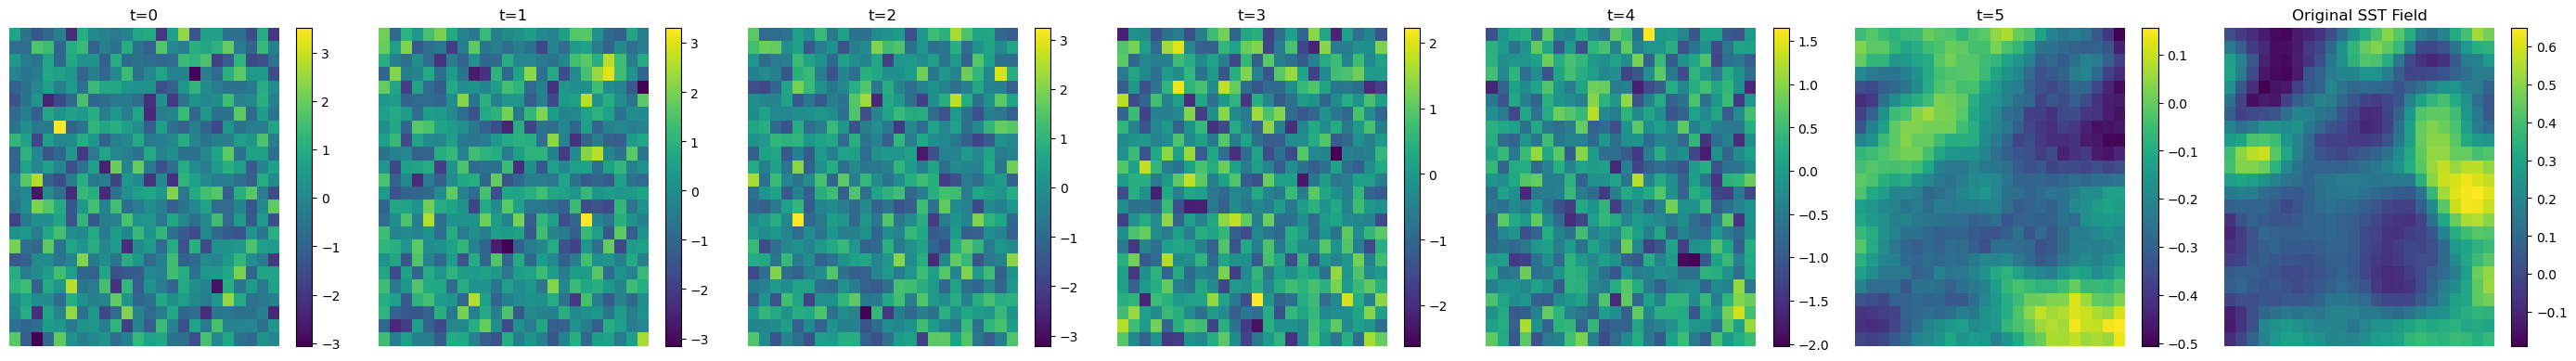

In [10]:
backward_sampler = ConditionalBackwardSampler(model, beta_scheduler, device)

past_sst, original_sst = train_ds[500]
past_sst, original_sst = torch.tensor(past_sst), torch.tensor(original_sst)
noisy_sst, _ = forward_sampler(
    original_sst, torch.tensor(forward_sampler.max_time_steps - 1))
recovered_ssts = []
recovered_sst = noisy_sst
for i in reversed(range(forward_sampler.max_time_steps)):
    recovered_sst = backward_sampler(recovered_sst, past_sst, i)

    if i % 200 == 0:
        recovered_ssts.append(recovered_sst)

nb_sst = len(recovered_ssts) + 1
fig, axes = plt.subplots(ncols=nb_sst, figsize=(4 * nb_sst, 4))
for t, (ax, sst) in enumerate(zip(axes, recovered_ssts)):
    ax.set_title(f'{t=}')
    cs = ax.pcolormesh(sst[0])
    fig.colorbar(cs, ax=ax)
    ax.axis('off')

ax = axes[-1]
cs = ax.pcolormesh(original_sst[0])
fig.colorbar(cs, ax=ax)
ax.set_title('Original SST Field')
ax.axis('off')
fig.tight_layout()

print(F.mse_loss(sst, original_sst))

#### Evaluate MSE with Test Dataset

  0%|          | 0/12 [00:00<?, ?it/s]

{'diff_err': 0.663634459177653, 'temp_err': 0.6636344542105993}

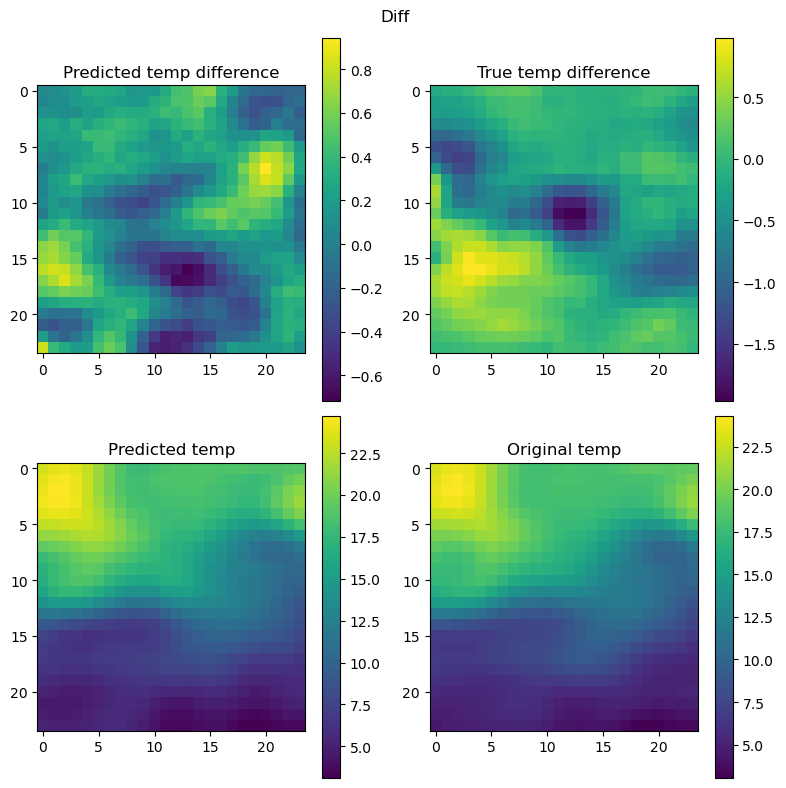

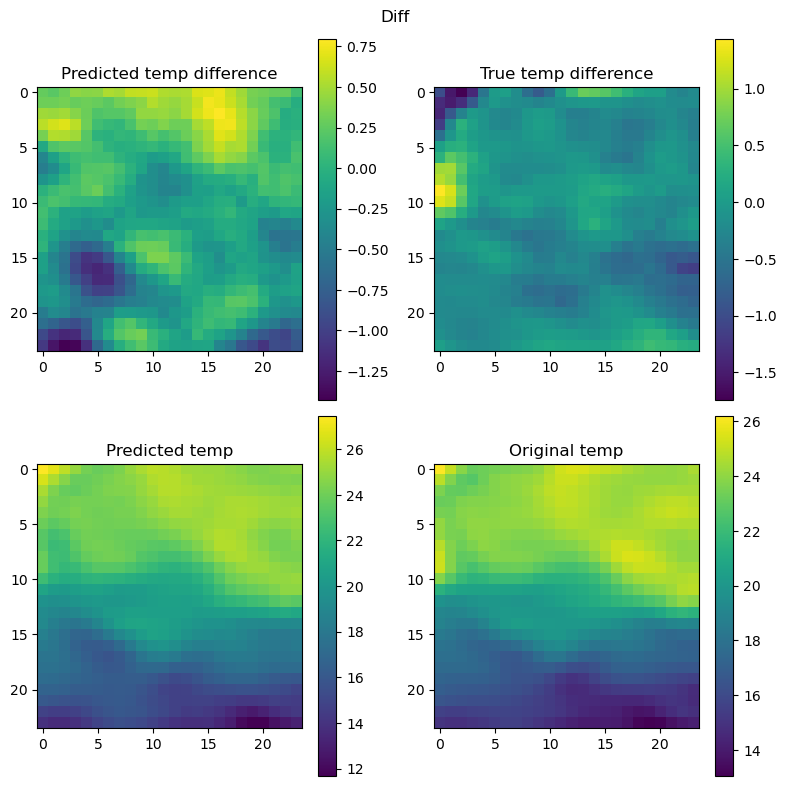

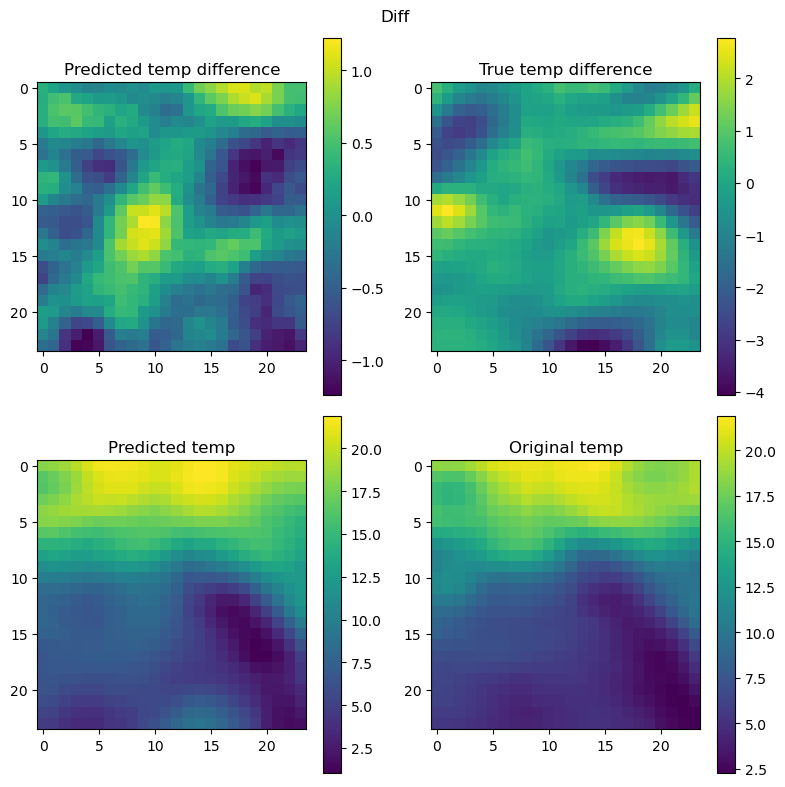

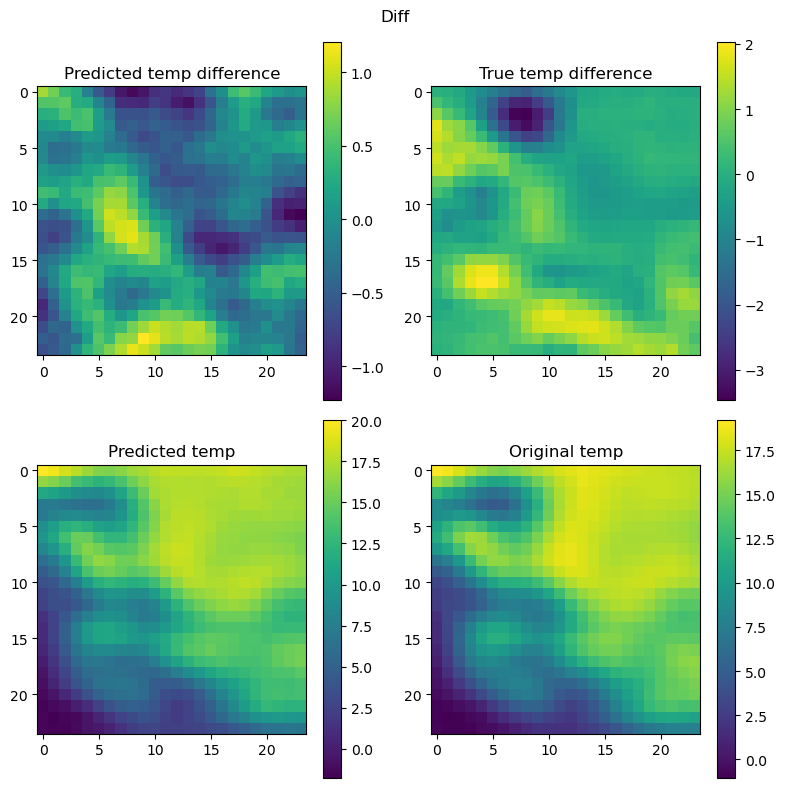

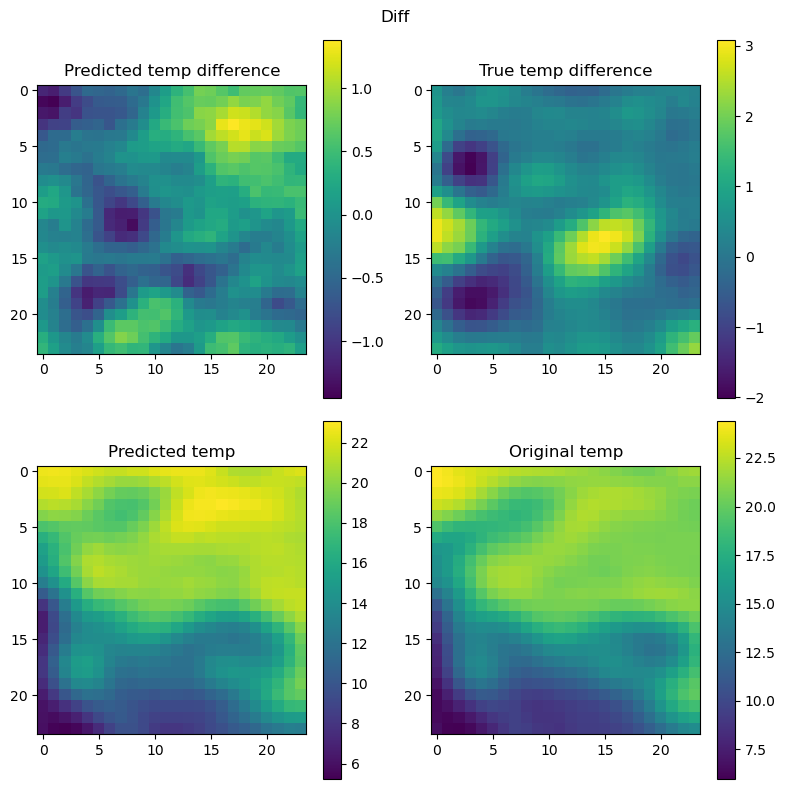

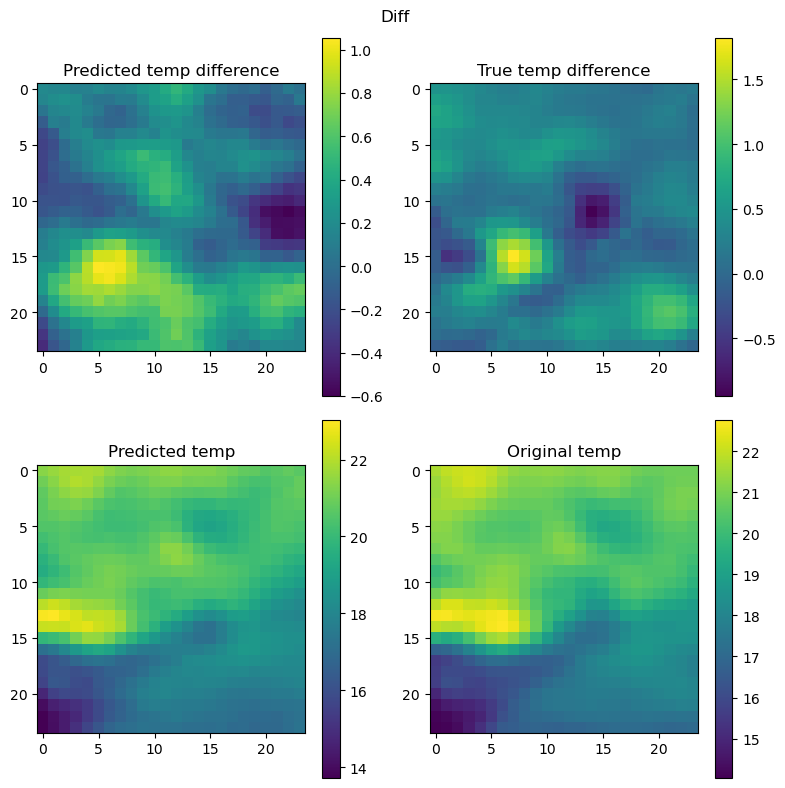

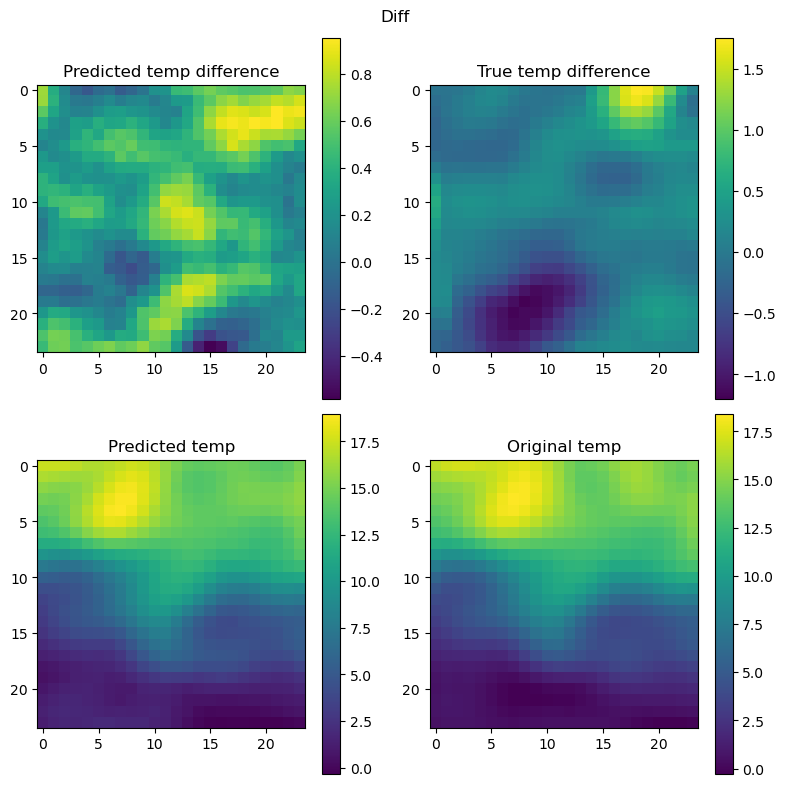

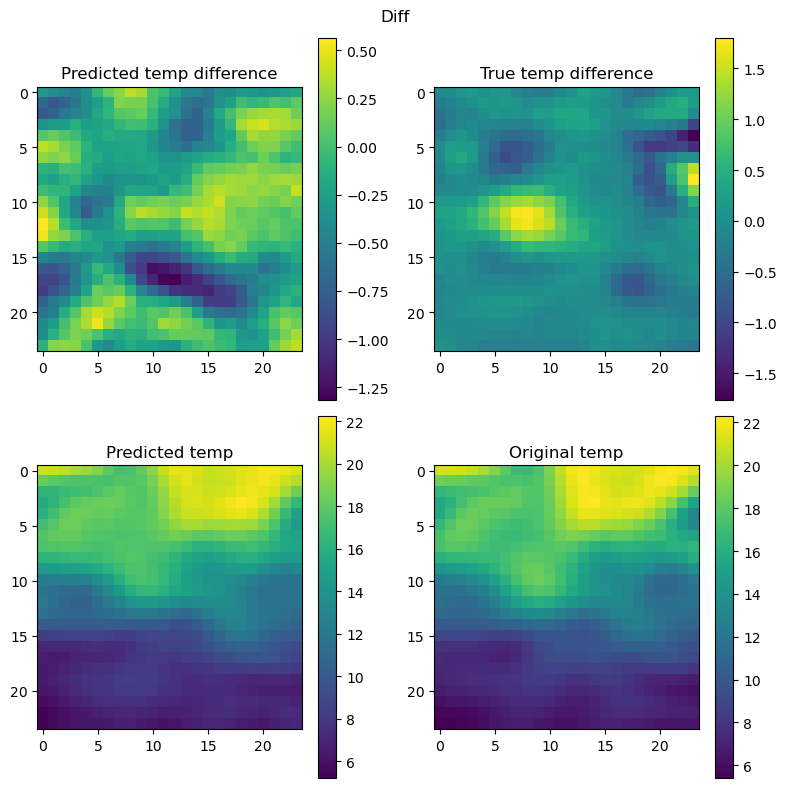

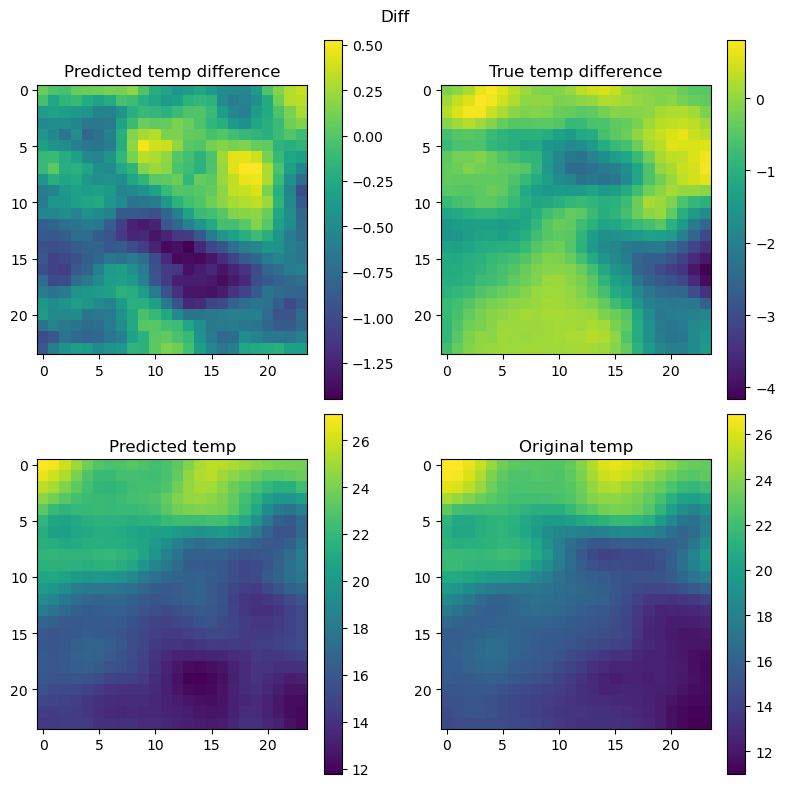

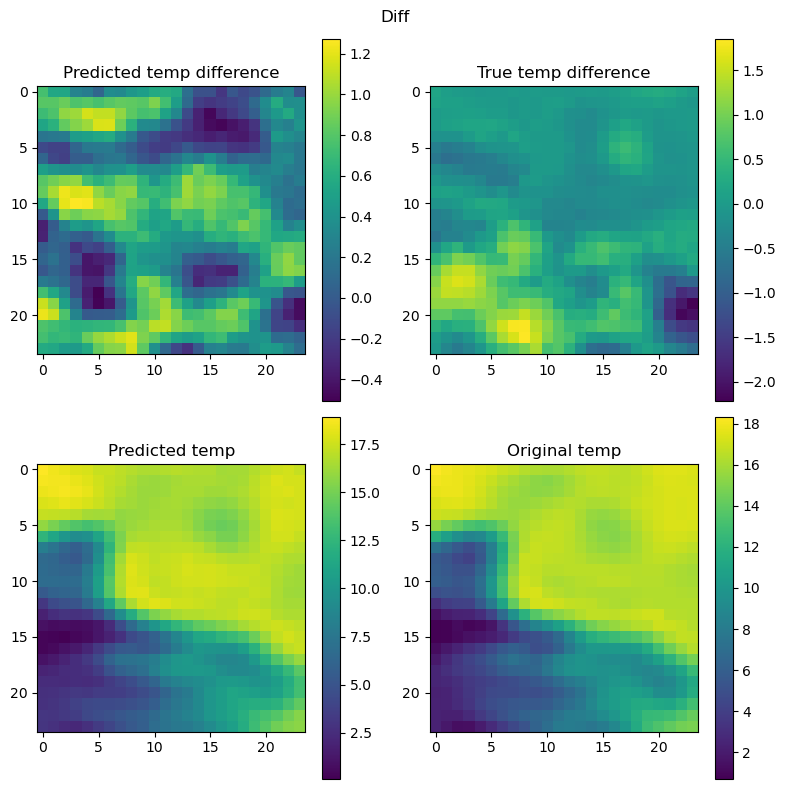

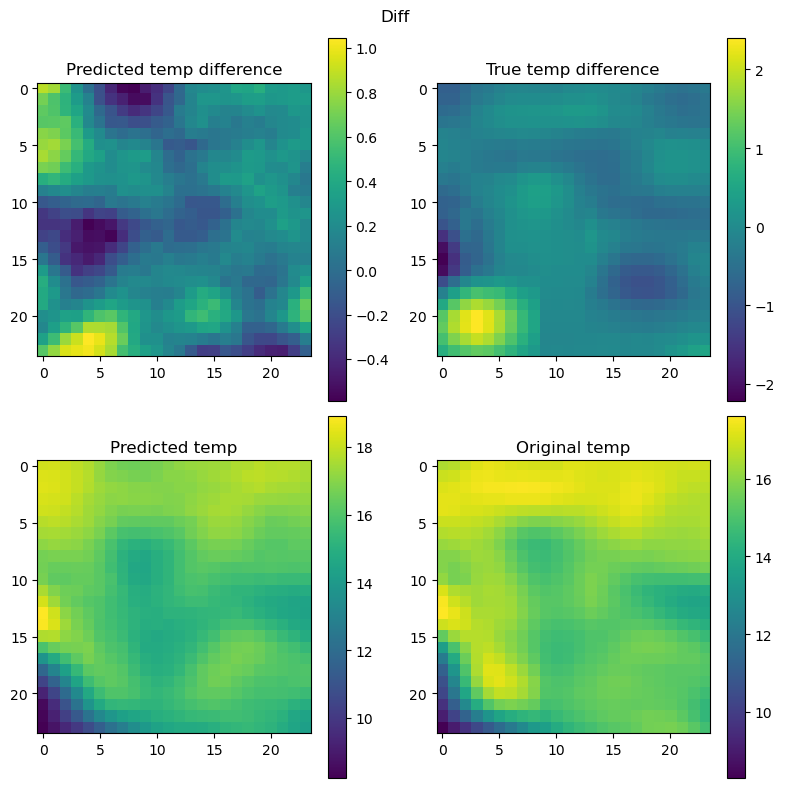

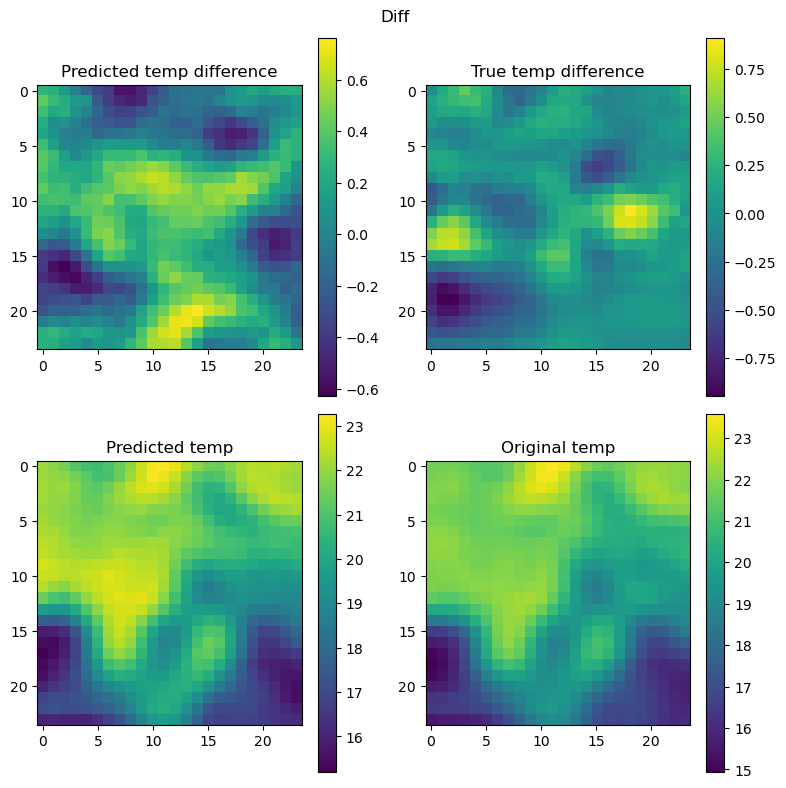

In [11]:
shown = False

@torch.no_grad()
def evaluate_mse_for_diff_ds(
        *,
        diff_dl: DataLoader,
        original_dl: DataLoader,
        backward_sampler: ConditionalBackwardSampler,
        max_time_steps: int,
        diff_temp_scaler: ScaleTemperature):
    assert len(diff_dl) == len(original_dl)

    nb_batches = len(diff_dl)
    diff_total_error = 0.
    temp_total_error = 0.

    for (X_diff, y_diff), (X, y) in tqdm(zip(diff_dl, original_dl), total=nb_batches):
        # Perform backward process.
        y_pred_diff = torch.randn_like(y_diff)

        # Feed the noisy diff sst into backward sampler to get original diff sst.
        for t in reversed(range(max_time_steps)):
            y_pred_diff = backward_sampler(y_pred_diff, X_diff, t)

        # Convert to the normal range.
        y_diff = diff_temp_scaler.inverse(y_diff)
        y_pred_diff = diff_temp_scaler.inverse(y_pred_diff.detach().cpu())

        diff_total_error += float(F.mse_loss(y_diff, y_pred_diff).item())

        # Calculate the predicted temperature.
        temp_pred = X[:, -1:] + y_pred_diff
        temp_total_error += float(F.mse_loss(y, temp_pred).item())

        # Plot results.
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
        ax = axes[0, 0]
        cs = ax.imshow(y_pred_diff[0, 0])
        ax.set_title('Predicted temp difference')
        fig.colorbar(cs, ax=ax)

        ax = axes[0, 1]
        cs = ax.imshow(y_diff[0, 0])
        ax.set_title('True temp difference')
        fig.colorbar(cs, ax=ax)

        ax = axes[1, 0]
        cs = ax.imshow(temp_pred[0, 0])
        ax.set_title('Predicted temp')
        fig.colorbar(cs, ax=ax)

        ax = axes[1, 1]
        cs = ax.imshow(y[0, 0])
        ax.set_title('Original temp')
        fig.colorbar(cs, ax=ax)
        fig.suptitle('Diff')
        fig.tight_layout()

    return dict(
        diff_err=diff_total_error / nb_batches,
        temp_err=temp_total_error / nb_batches,
    )


test_dataloader = DataLoader(test_ds, batch_size=256, num_workers=4)
test_diff_dataloader = DataLoader(test_diff_ds, batch_size=256, num_workers=4)
evaluate_mse_for_diff_ds(
    diff_dl=test_diff_dataloader,
    original_dl=test_dataloader,
    backward_sampler=backward_sampler,
    max_time_steps=forward_sampler.max_time_steps,
    diff_temp_scaler=temp_diff_scaler)